# Data Augmentation for Power Plant Security


## 1. Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BlipProcessor, BlipForConditionalGeneration, GPT2LMHeadModel, GPT2Tokenizer
from diffusers import StableDiffusionPipeline
from PIL import Image
import os
from tqdm import tqdm
from collections import defaultdict, Counter
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Oxford Pet Dataset

We'll start out by loading the Oxford Pet dataset. It contains 37 breeds of cats and dogs.  
We create 2 datasets: the original one normalized to help for CNN training, and the other for captioning using BLIP doesn't need that.

In [33]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_for_captioning = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

original_dataset = OxfordIIITPet(root="./data", split='trainval', download=True, transform=transform)
captioning_dataset = OxfordIIITPet(root="./data", split='trainval', download=False, transform=transform_for_captioning)

In [4]:
len(original_dataset)

3680

In [5]:
len(original_dataset.classes)

37

In [6]:
for i, class_name in enumerate(original_dataset.classes):
    print(f"Class {i:2d}: {class_name}")

Class  0: Abyssinian
Class  1: American Bulldog
Class  2: American Pit Bull Terrier
Class  3: Basset Hound
Class  4: Beagle
Class  5: Bengal
Class  6: Birman
Class  7: Bombay
Class  8: Boxer
Class  9: British Shorthair
Class 10: Chihuahua
Class 11: Egyptian Mau
Class 12: English Cocker Spaniel
Class 13: English Setter
Class 14: German Shorthaired
Class 15: Great Pyrenees
Class 16: Havanese
Class 17: Japanese Chin
Class 18: Keeshond
Class 19: Leonberger
Class 20: Maine Coon
Class 21: Miniature Pinscher
Class 22: Newfoundland
Class 23: Persian
Class 24: Pomeranian
Class 25: Pug
Class 26: Ragdoll
Class 27: Russian Blue
Class 28: Saint Bernard
Class 29: Samoyed
Class 30: Scottish Terrier
Class 31: Shiba Inu
Class 32: Siamese
Class 33: Sphynx
Class 34: Staffordshire Bull Terrier
Class 35: Wheaten Terrier
Class 36: Yorkshire Terrier


Let's take a look at some samples:

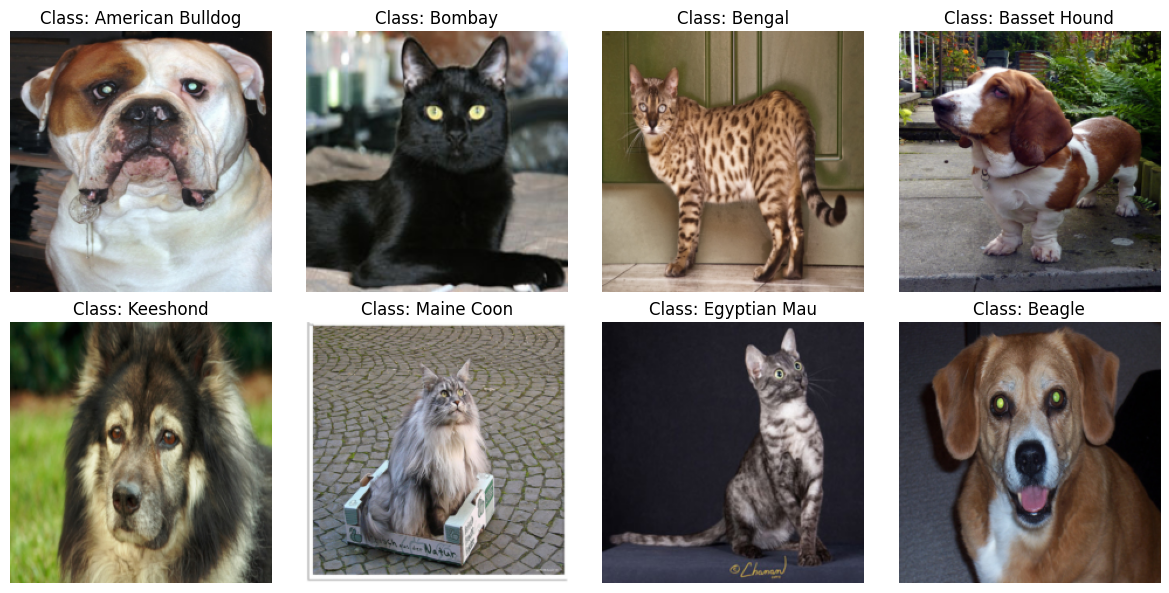

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

selected_classes = random.sample(range(len(original_dataset.classes)), 8)

for i in range(8):
    class_idx = selected_classes[i]
    class_indices = [j for j, (_, label) in enumerate(captioning_dataset) if label == class_idx]
    random_idx = random.choice(class_indices)

    img, label = captioning_dataset[random_idx]
    axes[i//4, i%4].imshow(img.permute(1, 2, 0))
    axes[i//4, i%4].set_title(f"Class: {original_dataset.classes[label]}")
    axes[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()

## 3. Image Captioning

Now we'll use BLIP to generate captions from 2 image samples of every class.

In [34]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
captioning_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

In [9]:
def generate_caption(image):
    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image)

    inputs = processor(image, return_tensors="pt").to(device)

    with torch.no_grad():
        out = captioning_model.generate(**inputs, max_length=50)

    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

In [10]:
samples_per_class = 2
num_classes = len(original_dataset.classes)
class_to_indices = defaultdict(list)

for idx in tqdm(range(len(original_dataset)), desc="Mapping classes"):
    _, label = original_dataset[idx]
    class_to_indices[label].append(idx)

original_captions = []
original_labels = []

for class_idx in range(num_classes):
    class_indices = class_to_indices[class_idx]
    class_name = original_dataset.classes[class_idx]

    sampled_from_class = random.sample(class_indices, min(samples_per_class, len(class_indices)))

    for idx in sampled_from_class:
        img, label = captioning_dataset[idx]
        caption = generate_caption(img)
        original_captions.append(caption)
        original_labels.append(label)


Mapping classes: 100%|██████████| 3680/3680 [00:27<00:00, 132.16it/s]


## 4. Text generation

Having the captions, now we can ask GPT-2 to generate text variants for every caption, making sure the type of animal and breed is included in the prompt.

In [11]:
def get_animal_type(breed_name):
    """Determine if the breed is a cat or dog"""

    cat_breeds = {
        'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
        'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
        'Siamese', 'Sphynx'
    }

    return "cat" if breed_name in cat_breeds else "dog"

In [12]:
def generate_text_variants(caption, breed_name, num_variants=3):
    animal_type = get_animal_type(breed_name)
    variants = []

    prompts = [
        f"Create a similar description of a {breed_name} {animal_type}: {caption}. Alternative {breed_name} {animal_type} description:",
        f"Describe this {breed_name} {animal_type} differently: {caption}. Different {breed_name} {animal_type}:",
        f"Rephrase this {breed_name} {animal_type} description: {caption}. {breed_name} {animal_type} variant:"
    ]

    for prompt in prompts[:num_variants]:
        inputs = text_tokenizer.encode(prompt, return_tensors="pt", max_length=120, truncation=True).to(device)

        with torch.no_grad():
            outputs = text_model.generate(
                inputs,
                max_length=inputs.shape[1] + 30,
                num_return_sequences=1,
                temperature=0.8,
                do_sample=True,
                pad_token_id=text_tokenizer.eos_token_id
            )

        generated_text = text_tokenizer.decode(outputs[0], skip_special_tokens=True)
        variant = generated_text[len(prompt):].strip().split('.')[0]

        if variant and len(variant) > 5:
            if breed_name.lower() not in variant.lower():
                variant = f"a {breed_name.lower()} {animal_type} {variant}"
            elif animal_type not in variant.lower():
                variant = f"a {breed_name.lower()} {animal_type} {variant}"
            variants.append(variant)

    return variants

In [13]:
text_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
text_tokenizer.pad_token = text_tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [14]:
all_text_descriptions = []
all_variant_labels = []

for caption, label in tqdm(zip(original_captions, original_labels), desc="Creating text variants"):
    breed_name = original_dataset.classes[label]
    variants = generate_text_variants(caption, breed_name, num_variants=3)

    for variant in variants:
        all_text_descriptions.append(variant)
        all_variant_labels.append(label)

Creating text variants: 0it [00:00, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Creating text variants: 74it [01:11,  1.04it/s]


In [30]:
all_text_descriptions[:10]

['a abyssinian cat A cat holding a white sheet of paper on top of a black surface (as opposed to the white sheet being a flat sheet of paper, which is',
 'The Cat from this Abyssinian cat has a very strange name',
 'a abyssinian cat cat with a large head, wings, head that is a bit larger than normal and wings that are quite long',
 'a abyssinian cat a cat sitting on the floor in a room with no furniture',
 'a abyssinian cat cat in a room?\n\nCats are sometimes described as "ghosts" [1][2] (which may be due to a discrepancy',
 "a abyssinian cat the following is a description of a cat that is not familiar with the cat (at least not in this sub) in the cat's original location",
 'a american bulldog dog a dog with a white collar',
 'a american bulldog dog a dog with a blue collar',
 'this dog has an American bulldog collar',
 'a american bulldog dog A dog running through a field of purple flowers']

## 5. Synthetic images generation

Now we're ready to generate new syntetic images from caption's variants by using Stable Difussion.

In [15]:
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16).to(device)
pipe.enable_attention_slicing()
pipe.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
def generate_images_from_text(descriptions, labels):
    synthetic_images = []
    synthetic_labels = []

    for description, label in tqdm(zip(descriptions, labels), desc="Generating images"):
        prompt = f"a high quality photo of {description}, detailed, realistic"

        try:
            with torch.no_grad():
                image = pipe(prompt, num_inference_steps=50, guidance_scale=9.0).images[0]

            image_tensor = transform(image)
            synthetic_images.append(image_tensor)
            synthetic_labels.append(label)

        except Exception as e:
            continue

    return synthetic_images, synthetic_labels

In [17]:
synthetic_images, synthetic_labels = generate_images_from_text(all_text_descriptions, all_variant_labels)

Generating images: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 1it [00:44, 44.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 2it [01:28, 44.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 3it [02:13, 44.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 4it [02:57, 44.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 5it [03:41, 44.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 6it [04:26, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 7it [05:10, 44.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 8it [05:54, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 9it [06:39, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 10it [07:23, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 11it [08:07, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 12it [08:52, 44.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 13it [09:36, 44.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 14it [10:20, 44.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 15it [11:04, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 16it [11:49, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 17it [12:33, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 18it [13:17, 44.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 19it [14:02, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 20it [14:46, 44.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 21it [15:30, 44.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 22it [16:15, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 23it [16:59, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 24it [17:43, 44.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 25it [18:27, 44.10s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 26it [19:11, 44.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 27it [19:55, 44.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 28it [20:39, 44.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 29it [21:23, 44.09s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 30it [22:07, 44.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 31it [22:52, 44.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 32it [23:36, 44.07s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 33it [24:20, 44.07s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 34it [25:04, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 35it [25:49, 44.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 36it [26:33, 44.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 37it [27:17, 44.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 38it [28:01, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 39it [28:45, 44.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 40it [29:30, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 41it [30:14, 44.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 42it [30:58, 44.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 43it [31:42, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 44it [32:27, 44.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 45it [33:11, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 46it [33:55, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 47it [34:40, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 48it [35:24, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 49it [36:08, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 50it [36:53, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 51it [37:37, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 52it [38:21, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 53it [39:06, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 54it [39:50, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 55it [40:34, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 56it [41:18, 44.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 57it [42:02, 44.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 58it [42:47, 44.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 59it [43:31, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 60it [44:15, 44.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 61it [45:00, 44.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 62it [45:44, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 63it [46:29, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 64it [47:13, 44.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 65it [47:58, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 66it [48:42, 44.46s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 67it [49:26, 44.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 68it [50:11, 44.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 69it [50:55, 44.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 70it [51:40, 44.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 71it [52:24, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 72it [53:08, 44.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 73it [53:53, 44.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 74it [54:37, 44.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 75it [55:21, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 76it [56:05, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 77it [56:50, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 78it [57:34, 44.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 79it [58:18, 44.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 80it [59:02, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 81it [59:46, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 82it [1:00:31, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 83it [1:01:15, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 84it [1:02:00, 44.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 85it [1:02:45, 44.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 86it [1:03:29, 44.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 87it [1:04:13, 44.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 88it [1:04:57, 44.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 89it [1:05:42, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 90it [1:06:26, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 91it [1:07:10, 44.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 92it [1:07:54, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 93it [1:08:38, 44.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 94it [1:09:23, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 95it [1:10:07, 44.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 96it [1:10:51, 44.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 97it [1:11:36, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 98it [1:12:20, 44.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 99it [1:13:04, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 100it [1:13:49, 44.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 101it [1:14:33, 44.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 102it [1:15:17, 44.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 103it [1:16:02, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 104it [1:16:46, 44.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 105it [1:17:30, 44.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 106it [1:18:14, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 107it [1:18:59, 44.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 108it [1:19:43, 44.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 109it [1:20:27, 44.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 110it [1:21:12, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 111it [1:21:56, 44.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 112it [1:22:40, 44.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 113it [1:23:24, 44.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 114it [1:24:09, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 115it [1:24:53, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 116it [1:25:37, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 117it [1:26:21, 44.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 118it [1:27:05, 44.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 119it [1:27:50, 44.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 120it [1:28:34, 44.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 121it [1:29:18, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 122it [1:30:03, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 123it [1:30:47, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 124it [1:31:31, 44.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 125it [1:32:16, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 126it [1:33:00, 44.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 127it [1:33:45, 44.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 128it [1:34:29, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 129it [1:35:13, 44.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 130it [1:35:57, 44.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 131it [1:36:42, 44.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 132it [1:37:26, 44.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 133it [1:38:10, 44.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 134it [1:38:54, 44.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 135it [1:39:38, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 136it [1:40:22, 44.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 137it [1:41:07, 44.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 138it [1:41:51, 44.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 139it [1:42:35, 44.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 140it [1:43:19, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 141it [1:44:03, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 142it [1:44:48, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 143it [1:45:32, 44.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 144it [1:46:16, 44.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 145it [1:47:00, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 146it [1:47:44, 44.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 147it [1:48:29, 44.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 148it [1:49:13, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 149it [1:49:57, 44.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 150it [1:50:41, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 151it [1:51:25, 44.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 152it [1:52:10, 44.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 153it [1:52:54, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 154it [1:53:38, 44.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 155it [1:54:23, 44.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 156it [1:55:07, 44.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 157it [1:55:52, 44.45s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 158it [1:56:36, 44.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 159it [1:57:21, 44.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 160it [1:58:05, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 161it [1:58:49, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 162it [1:59:34, 44.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 163it [2:00:18, 44.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 164it [2:01:03, 44.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 165it [2:01:47, 44.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 166it [2:02:31, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 167it [2:03:16, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 168it [2:04:00, 44.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 169it [2:04:45, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 170it [2:05:29, 44.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 171it [2:06:14, 44.48s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 172it [2:06:58, 44.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 173it [2:07:43, 44.52s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 174it [2:08:27, 44.52s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 175it [2:09:12, 44.55s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 176it [2:09:56, 44.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 177it [2:10:40, 44.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 178it [2:11:25, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 179it [2:12:09, 44.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 180it [2:12:53, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 181it [2:13:38, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 182it [2:14:22, 44.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 183it [2:15:06, 44.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 184it [2:15:51, 44.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 185it [2:16:35, 44.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 186it [2:17:20, 44.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 187it [2:18:04, 44.46s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 188it [2:18:49, 44.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 189it [2:19:33, 44.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 190it [2:20:18, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 191it [2:21:02, 44.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 192it [2:21:46, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 193it [2:22:31, 44.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 194it [2:23:15, 44.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 195it [2:24:00, 44.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 196it [2:24:44, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 197it [2:25:29, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 198it [2:26:13, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 199it [2:26:57, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 200it [2:27:42, 44.46s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 201it [2:28:26, 44.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 202it [2:29:11, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 203it [2:29:55, 44.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 204it [2:30:39, 44.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 205it [2:31:24, 44.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 206it [2:32:08, 44.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 207it [2:32:52, 44.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 208it [2:33:37, 44.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 209it [2:34:21, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 210it [2:35:06, 44.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 211it [2:35:50, 44.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 212it [2:36:34, 44.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 213it [2:37:19, 44.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 214it [2:38:03, 44.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 215it [2:38:48, 44.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 216it [2:39:32, 44.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 217it [2:40:16, 44.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 218it [2:41:01, 44.48s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 219it [2:41:45, 44.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating images: 220it [2:42:30, 44.32s/it]


We're adding 220 new synthetic images to expand the original dataset, let's take a look at a sample of the new images:

In [32]:
len(synthetic_images)

220

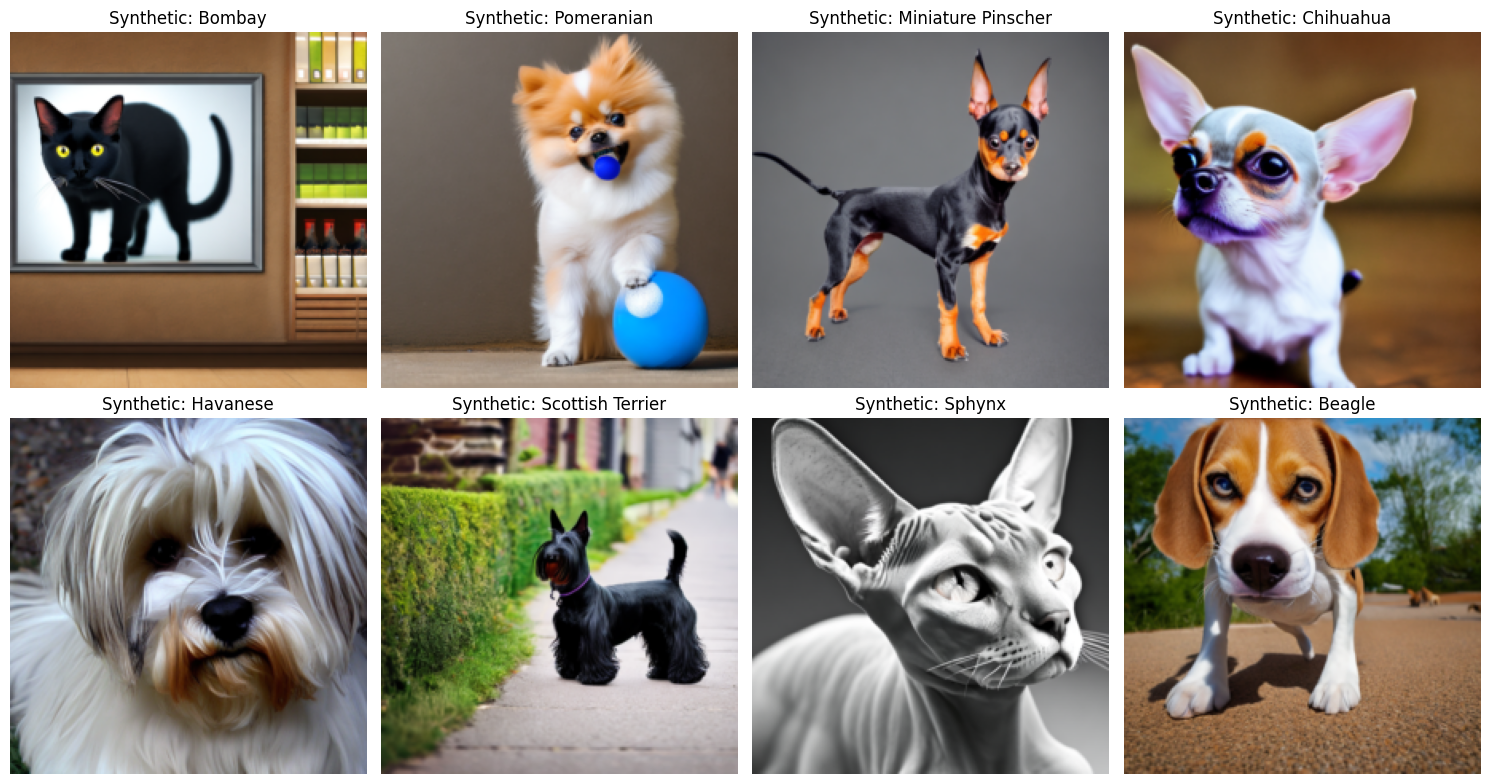

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
selected_classes = random.sample(range(num_classes), 8)

for i in range(8):
    class_idx = selected_classes[i]

    matching_syn_indices = [idx for idx, syn_label in enumerate(synthetic_labels) if syn_label == class_idx]
    if matching_syn_indices:
        syn_idx = random.choice(matching_syn_indices)
        syn_img = synthetic_images[syn_idx]
        syn_img_display = syn_img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        syn_img_display = torch.clamp(syn_img_display, 0, 1)

        axes[i//4, i%4].imshow(syn_img_display.permute(1, 2, 0))
        axes[i//4, i%4].set_title(f"Synthetic: {original_dataset.classes[class_idx]}")
        axes[i//4, i%4].axis('off')
    else:
        axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

In [25]:
class ExtendedDataset(Dataset):
    def __init__(self, original_dataset, synthetic_images, synthetic_labels):
        self.original_dataset = original_dataset
        self.synthetic_images = synthetic_images
        self.synthetic_labels = synthetic_labels

    def __len__(self):
        return len(self.original_dataset) + len(self.synthetic_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            synthetic_idx = idx - len(self.original_dataset)
            return self.synthetic_images[synthetic_idx], self.synthetic_labels[synthetic_idx]

extended_dataset = ExtendedDataset(original_dataset, synthetic_images, synthetic_labels)

## 6. Classification Model

Let's build a CNN to train both original and extended datasets and compare their performance, in order to confirm the new data we've just created is adding value.

In [20]:
class PetClassifier(nn.Module):
    def __init__(self, num_classes=37):
        super(PetClassifier, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
def train_classifier(dataset, model_name, epochs=15):
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    test_size = dataset_size - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = PetClassifier(num_classes=37).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

    model.eval()
    all_predictions = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    avg_test_loss = test_loss / len(test_loader)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'test_loss': avg_test_loss,
        'train_losses': train_losses
    }

    return model, metrics

## 7. Model Training

In [23]:
model_original, metrics_original = train_classifier(original_dataset, "Original Dataset", epochs=15)

Epoch 15/15: 100%|██████████| 92/92 [00:32<00:00,  2.81it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
model_extended, metrics_extended = train_classifier(extended_dataset, "Extended Dataset", epochs=15)

Epoch 15/15: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 8. Performance Analysis

In [27]:
def print_comparison(metrics_original, metrics_extended):
    print("\n" + "="*60)
    print("PERFORMANCE COMPARISON")
    print("="*60)

    print(f"{'Metric':<15} {'Original Dataset':<18} {'Extended Dataset':<18} {'Improvement':<15}")
    print("-" * 70)

    metrics_names = ['accuracy', 'precision', 'recall', 'f1']

    for metric in metrics_names:
        original_val = metrics_original[metric]
        extended_val = metrics_extended[metric]
        improvement = ((extended_val - original_val) / original_val) * 100

        print(f"{metric.capitalize():<15} {original_val:<18.4f} {extended_val:<18.4f} {improvement:>+7.2f}%")

    print("-" * 70)
    print(f"{'Test Loss':<15} {metrics_original['test_loss']:<18.4f} {metrics_extended['test_loss']:<18.4f}")

    return {
        'accuracy_improvement': ((metrics_extended['accuracy'] - metrics_original['accuracy']) / metrics_original['accuracy']) * 100,
        'f1_improvement': ((metrics_extended['f1'] - metrics_original['f1']) / metrics_original['f1']) * 100
    }

improvements = print_comparison(metrics_original, metrics_extended)


PERFORMANCE COMPARISON
Metric          Original Dataset   Extended Dataset   Improvement    
----------------------------------------------------------------------
Accuracy        0.0788             0.0962              +22.02%
Precision       0.0702             0.0898              +27.92%
Recall          0.0788             0.0962              +22.02%
F1              0.0503             0.0711              +41.40%
----------------------------------------------------------------------
Test Loss       3.3695             3.2814            


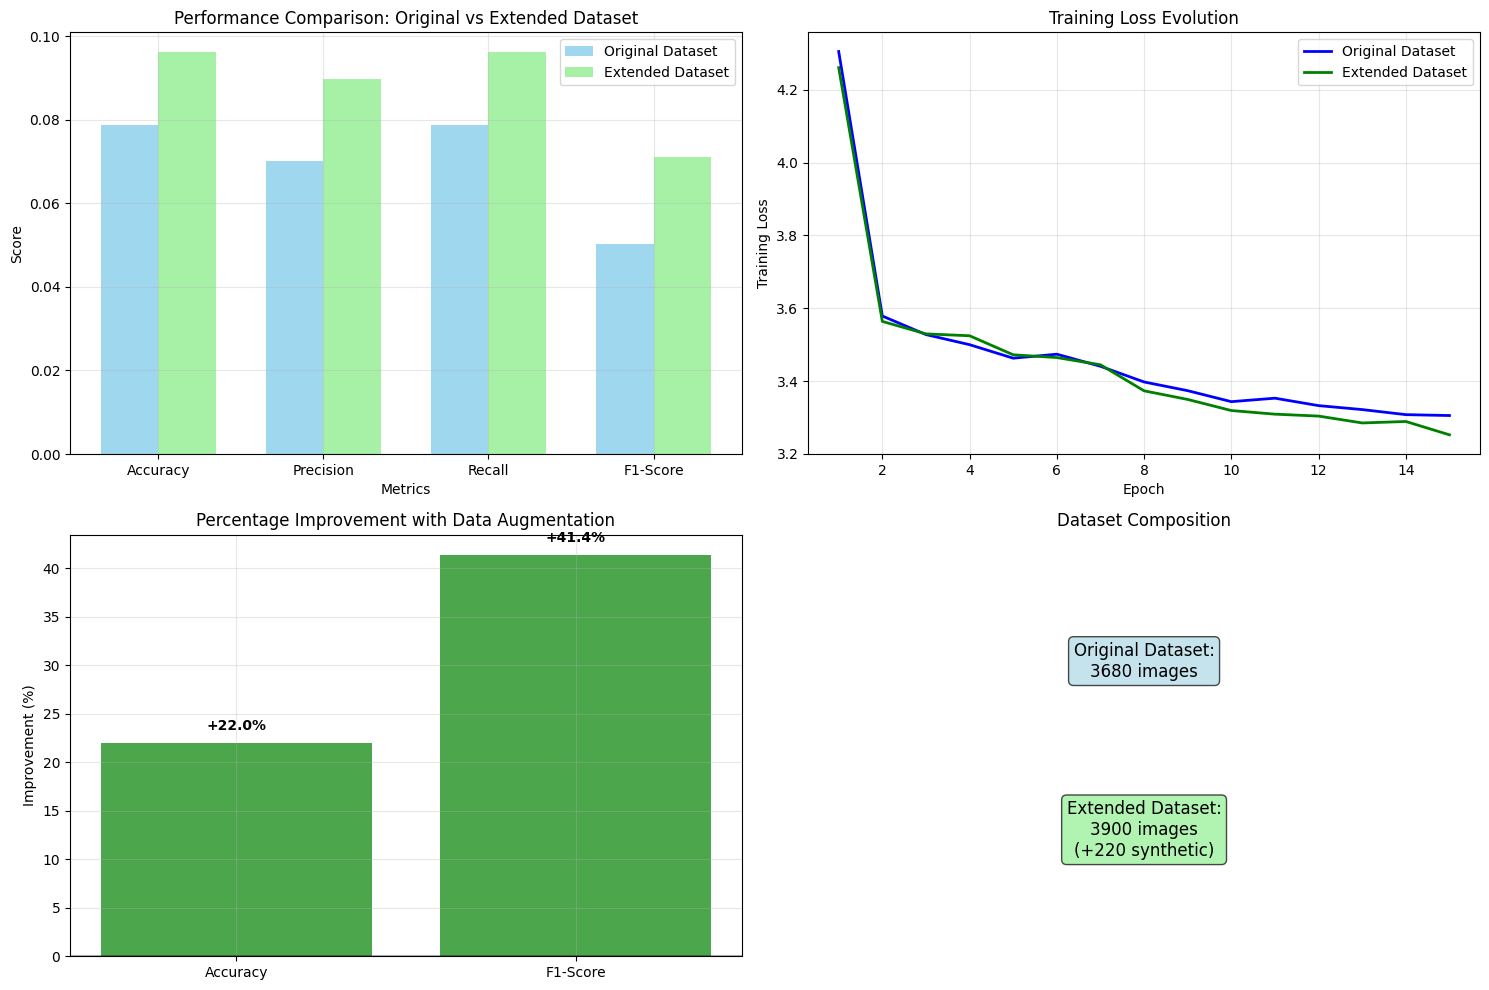

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
original_values = [metrics_original['accuracy'], metrics_original['precision'],
                 metrics_original['recall'], metrics_original['f1']]
extended_values = [metrics_extended['accuracy'], metrics_extended['precision'],
                   metrics_extended['recall'], metrics_extended['f1']]

x = np.arange(len(metrics_names))
width = 0.35

ax1.bar(x - width/2, original_values, width, label='Original Dataset', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, extended_values, width, label='Extended Dataset', alpha=0.8, color='lightgreen')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Performance Comparison: Original vs Extended Dataset')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names)
ax1.legend()
ax1.grid(True, alpha=0.3)

epochs_range = range(1, len(metrics_original['train_losses']) + 1)
ax2.plot(epochs_range, metrics_original['train_losses'], 'b-', label='Original Dataset', linewidth=2)
ax2.plot(epochs_range, metrics_extended['train_losses'], 'g-', label='Extended Dataset', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Loss')
ax2.set_title('Training Loss Evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

improvement_metrics = ['Accuracy', 'F1-Score']
improvement_values = [improvements['accuracy_improvement'], improvements['f1_improvement']]
colors = ['green' if x > 0 else 'red' for x in improvement_values]

bars = ax3.bar(improvement_metrics, improvement_values, color=colors, alpha=0.7)
ax3.set_ylabel('Improvement (%)')
ax3.set_title('Percentage Improvement with Data Augmentation')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)

for bar, value in zip(bars, improvement_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3),
             f'+{value:.1f}%' if value > 0 else f'{value:.1f}%',
             ha='center', va='bottom' if value > 0 else 'top', fontweight='bold')

ax4.text(0.5, 0.7, f'Original Dataset:\n{len(original_dataset)} images',
         ha='center', va='center', transform=ax4.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax4.text(0.5, 0.3, f'Extended Dataset:\n{len(extended_dataset)} images\n(+{len(synthetic_images)} synthetic)',
         ha='center', va='center', transform=ax4.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
ax4.set_title('Dataset Composition')
ax4.axis('off')

plt.tight_layout()
plt.show()

## 9. Conclusions

We can confirm that the new synthetic images we've added to the original dataset by usign those techniques actually helped out to improve the metrics.

31/08/2025 Pablo Di Marco